In [1]:
# load package
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt


# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/esunfrauddetectiongame1809/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')
#你可以选择修改 ast_note_iteractively kernel 选项来使得 Jupyter 为每一行的变量或语句执行这个操作，以便你可以立即看到多条语句一起输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
train=pd.read_csv('train_diss.csv',encoding='big5')
test=pd.read_csv('test_diss.csv',encoding='big5')
data=train.append(test, ignore_index=True)
del(train, test)

In [3]:
data['s_in_a_Day']= data['DATETIME']%(60*60*24)
import math
data['h_in_a_Day']= data['s_in_a_Day'].map(lambda x: math.floor(x/(60*60)))

In [4]:
import re
def strip_upper(x):
    if x == np.nan:
        return x
    elif type(x) != str:
        a=str(x)
        b=re.sub('\s','',a)
        c=b.upper()
        return c
    else:
        b=re.sub('\s','',x)
        c=b.upper()
        return c

In [5]:
data['SCITY'] = data['SCITY'].apply(lambda x : strip_upper(x))
data['STOCN'] = data['STOCN'].apply(lambda x : strip_upper(x))
data['ACQIC'] = data['ACQIC'].apply(lambda x : strip_upper(x))

In [6]:
data.fillna({'MCHNO':'others','MCC':'others'}, inplace=True)

### Start embedding ACQIC

In [7]:
X_dummies = data[['ACQIC','FRAUD_IND']]
X_dummies= pd.get_dummies(X_dummies, prefix='ACQIC', sparse=True)

In [8]:
X_dummies.head()

,FRAUD_IND,ACQIC_0.0,ACQIC_1.0,ACQIC_10.0,ACQIC_100.0,ACQIC_100062.0,ACQIC_100257.0,ACQIC_100329.0,ACQIC_100338.0,ACQIC_100401.0,...,ACQIC_99800000.0,ACQIC_998013.0,ACQIC_998105.0,ACQIC_999083.0,ACQIC_999359.0,ACQIC_999511.0,ACQIC_999751.0,ACQIC_999854.0,ACQIC_999957.0,ACQIC_NAN
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X_dummies_train= X_dummies[pd.notnull(X_dummies['FRAUD_IND'])]

In [10]:
def get_k_col_name_list(k, prefix='col'):
    L=[]
    for a in range(k):
        col= prefix+'_'+str(a)
        L.append(col)
    return L

In [11]:
import logging
def X_embedding_fm(emb_X_input, X_dummies, X_dummies_train, fm_model):
    logging.info('Fit the FM model and derive the embedding values')
    fm_model.fit(X_dummies_train, emb_X_input['FRAUD_IND']) #change Y HERE!
    emb_weight = fm_model.weights[1]
    X_emb = np.matmul(X_dummies.values, emb_weight)
    X_emb = pd.DataFrame(X_emb, columns=get_k_col_name_list(k, prefix='ACQIC'))
    #cuisine_emb = pd.DataFrame(cuisine_emb, columns=['cuisine'+edu_state[state]+str(i) for i in range(emb_weight.shape[1])])
    #return emb_weight, X_emb #想要看weight再return出來
    return X_emb

In [12]:
import xlearn as xl
#fm_model = xl.FMModel(task='binary', init=0.1, epoch=10, k=64, lr=0.1, reg_lambda=0.1, opt='sgd', metric='auc')
fm_model = xl.FMModel(task='binary', init=0.66, epoch=10, k=32, lr=0.05, reg_lambda=0.1, opt='adagrad', metric='auc')
k=32

In [13]:
dataTrain = data[pd.notnull(data['FRAUD_IND'])]
dataTest = data[~pd.notnull(data['FRAUD_IND'])]

In [14]:
emb_X_input = dataTrain[['TXKEY','FRAUD_IND']]
X_dummies= X_dummies.drop(['FRAUD_IND'], axis=1)
X_dummies_train= X_dummies_train.drop(['FRAUD_IND'], axis=1)
del (dataTrain, dataTest)

In [15]:
X_emb = X_embedding_fm(emb_X_input, X_dummies, X_dummies_train, fm_model)

In [16]:
X_emb.head()

,ACQIC_0,ACQIC_1,ACQIC_2,ACQIC_3,ACQIC_4,ACQIC_5,ACQIC_6,ACQIC_7,ACQIC_8,ACQIC_9,...,ACQIC_22,ACQIC_23,ACQIC_24,ACQIC_25,ACQIC_26,ACQIC_27,ACQIC_28,ACQIC_29,ACQIC_30,ACQIC_31
0,4.935650e-10,2.084680e-10,5.698420e-11,4.322090e-10,4.079060e-10,3.897260e-10,2.319420e-10,3.674660e-10,1.006850e-10,1.756550e-10,...,1.998730e-10,4.103870e-10,8.039800e-11,1.657600e-10,1.493510e-10,1.295410e-10,2.616030e-10,3.551740e-10,2.107610e-10,1.939890e-10
1,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,...,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
2,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,...,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
3,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,...,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
4,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,...,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43


In [17]:
X_emb.ACQIC_0.max()

0.116671

In [18]:
data=pd.concat([data,X_emb], axis=1)

In [19]:
data.head()

,ACCT_VINTAGE,ACQIC,AGE,AGNO,ANDFG,APPFG,AVAILABLE_LIMIT_AMT,BNSFG,BNSPT,BONUS_POINTS,...,ACQIC_22,ACQIC_23,ACQIC_24,ACQIC_25,ACQIC_26,ACQIC_27,ACQIC_28,ACQIC_29,ACQIC_30,ACQIC_31
0,137.0,88547000.0,37,0032,0,0,159308.0,0,0,314.0,...,1.998730e-10,4.103870e-10,8.039800e-11,1.657600e-10,1.493510e-10,1.295410e-10,2.616030e-10,3.551740e-10,2.107610e-10,1.939890e-10
1,150.0,493817.0,34,A013,0,0,108393.0,0,0,150.0,...,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
2,171.0,431330.0,48,A013,0,0,126795.0,0,0,594.0,...,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
3,92.0,493817.0,38,0032,0,1,231316.0,0,0,0.0,...,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
4,76.0,431330.0,29,0092,0,0,-6265.0,0,0,1978.0,...,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43


### Create other ratio features

In [20]:
num_aggregations = {
        'ECFG': [ 'mean'],
        'INSFG': [ 'mean'],
        'BNSFG': [ 'mean'],
        'FLAM1': [ 'mean'],
        'FALLBACK_IND':[ 'mean'],
        'ETYMD':[ 'nunique'],
        'h_in_a_Day':[ 'nunique']
}

# MCHNO info
fraud_agg = data.groupby('MCHNO').agg({**num_aggregations})
fraud_agg.columns = pd.Index([e[0] + "_MCHNO_" + e[1].upper() for e in fraud_agg.columns.tolist()])

# left join to df
data = data.join(fraud_agg, how='left', on='MCHNO')
del fraud_agg

In [21]:
num_aggregations = {
        'ECFG': [ 'mean'],
        'INSFG': [ 'mean'],
        'BNSFG': [ 'mean'],
        #'BNSPT':[ 'mean'],
        #'FLAM1': [ 'mean'],
        'FALLBACK_IND':[ 'mean'],
        'ETYMD':[ 'nunique'],
        'STOCN':[ 'nunique']
}

# SCITY info
fraud_agg = data.groupby('SCITY').agg({**num_aggregations})
fraud_agg.columns = pd.Index([e[0] + "_SCITY_" + e[1].upper() for e in fraud_agg.columns.tolist()])

# left join to df
data = data.join(fraud_agg, how='left', on='SCITY')
del fraud_agg

In [22]:
num_aggregations = {
        'ECFG': [ 'mean'],
        'INSFG': [ 'mean'],
        'BNSFG': [ 'mean'],
        #'BNSPT':[ 'mean'],
        #'FLAM1': [ 'mean'],
        'FALLBACK_IND':[ 'mean']
}

# SCITY info
fraud_agg = data.groupby('STOCN').agg({**num_aggregations})
fraud_agg.columns = pd.Index([e[0] + "_STOCN_" + e[1].upper() for e in fraud_agg.columns.tolist()])

# left join to df
data = data.join(fraud_agg, how='left', on='STOCN')
del fraud_agg

In [23]:
num_aggregations = {
        'ECFG': [ 'mean'],
        'h_in_a_Day':[ 'nunique']
}

# SCITY info
fraud_agg = data.groupby('ACQIC').agg({**num_aggregations})
fraud_agg.columns = pd.Index([e[0] + "_ACQIC_" + e[1].upper() for e in fraud_agg.columns.tolist()])

# left join to df
data = data.join(fraud_agg, how='left', on='ACQIC')
del fraud_agg

In [24]:
data= data.astype({'AGNO':'category', 'CATP1':'category', 'CC_CUST_LEVEL':'category', 'CONTP':'category', 'CUORG':'category', 'MCC':'category',
       'MCHNO':'category', 'SCITY':'category', 'STOCN':'category', 'TSCFG':'category','h_in_a_Day':'category','ETYMD':'category','ACQIC':'category'})
#, 'PAY_TYPE':'category', 'POSITION_CODE':'category'

In [25]:
dataTrain = data[pd.notnull(data['FRAUD_IND'])]
dataTest = data[~pd.notnull(data['FRAUD_IND'])]
dataTrain.columns
del(data)

Index(['ACCT_VINTAGE', 'ACQIC', 'AGE', 'AGNO', 'ANDFG', 'APPFG',
       'AVAILABLE_LIMIT_AMT', 'BNSFG', 'BNSPT', 'BONUS_POINTS',
       ...
       'BNSFG_SCITY_MEAN', 'FALLBACK_IND_SCITY_MEAN', 'ETYMD_SCITY_NUNIQUE',
       'STOCN_SCITY_NUNIQUE', 'ECFG_STOCN_MEAN', 'INSFG_STOCN_MEAN',
       'BNSFG_STOCN_MEAN', 'FALLBACK_IND_STOCN_MEAN', 'ECFG_ACQIC_MEAN',
       'h_in_a_Day_ACQIC_NUNIQUE'],
      dtype='object', length=112)

In [26]:
dataTrain = dataTrain.drop(['ACQIC','CANO','CHID','PAY_TYPE', 'POSITION_CODE','REVOLVING_AMT', 'REVOLVING_INTEREST','s_in_a_Day'], axis=1)
dataTest = dataTest.drop(['TXKEY','FRAUD_IND','ACQIC','CANO','CHID','PAY_TYPE', 'POSITION_CODE','REVOLVING_AMT', 'REVOLVING_INTEREST','s_in_a_Day'], axis=1)
X_feature = dataTrain.drop(['TXKEY','FRAUD_IND'], axis=1)
y_t =dataTrain['FRAUD_IND']

In [27]:
#把上面dataTrain.columns的結果貼到dataTrain，再去掉'Survived'
from sklearn.model_selection import train_test_split
#拿掉feature_importances低的因子
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_t, test_size=0.3, random_state=0)

In [28]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [29]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators = 150, random_state=0) #, objective = 'binary'


param_grid = {
    'objective':['binary'],
    'learning_rate': [0.11], 
    'num_leaves': [64],
    'feature_fraction': [0.7],
    'bagging_fraction': [0.95],
    'max_depth':[10],
    #'max_bin': [6],
    'bagging_freq':[5],
    #'lambda_l1': [40] , #[44,133] then 44 [44,88] then 44 np.arange(38,44,1) np.arange(16,20,1)
    #'lambda_l2': [7] ,#np.arange(11,15,1) then 13
    'reg_alpha':[15] ,
    #'min_split_gain': [0.04], 
    'min_child_weight': [2] 
}

LGBM_grid = GridSearchCV(estimator, param_grid,scoring='roc_auc',cv=4)
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators = 150, random_state=0 ,
                                     objective = LGBM_grid.best_params_['objective'],
                                     learning_rate = LGBM_grid.best_params_['learning_rate'],
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                             bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              #max_bin = LGBM_grid.best_params_['max_bin'],
                                bagging_freq = LGBM_grid.best_params_['bagging_freq'],
                              #lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              #lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                              reg_alpha = LGBM_grid.best_params_['reg_alpha'],
                            #min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight']
                                    )
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print("Predicting is over")

Start training...


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=150,
        n_jobs=-1, num_leaves=31, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'objective': ['binary'], 'learning_rate': [0.11], 'num_leaves': [64], 'feature_fraction': [0.7], 'bagging_fraction': [0.95], 'max_depth': [10], 'bagging_freq': [5], 'reg_alpha': [15], 'min_child_weight': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Best parameters found by grid search are: {'bagging_fraction': 0.95, 'bagging_freq': 5, 'feature_fraction': 0.7, 'learning_rate': 0.11, 'max_depth': 10, 'min_child_weight': 2, 'num_leaves': 64, 'objective': 'binary', 'reg_alpha': 15}
Start predicting...
Predicting is over


Accuracy:0.977
Classification report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    137148
         1.0       0.92      0.91      0.92     21865

   micro avg       0.98      0.98      0.98    159013
   macro avg       0.95      0.95      0.95    159013
weighted avg       0.98      0.98      0.98    159013

Confusion matrix
[[135447   1701]
 [  1933  19932]]
ROC AUC Score
0.9933129016923242
Feature importances: [261, 434, 789, 30, 91, 261, 0, 0, 269, 246, 15, 95, 59, 397, 78, 2, 220, 87, 225, 13, 4, 284, 110, 127, 271, 6, 347, 6, 109, 66, 1, 2, 1, 274, 56, 32, 13, 5, 8, 91, 27, 852, 997, 0, 174, 4, 26, 690, 191, 16, 495, 5, 10, 4, 4, 8, 4, 4, 3, 2, 4, 6, 7, 2, 6, 2, 10, 7, 5, 7, 9, 4, 5, 7, 4, 5, 8, 7, 6, 1, 5, 3, 6, 27, 4, 2, 65, 7, 9, 65, 34, 5, 1, 16, 6, 3, 27, 12, 4, 14, 53, 3]
Plot feature importances...


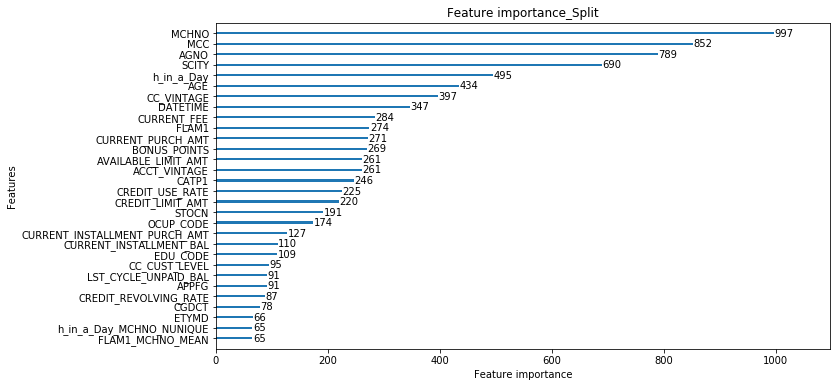

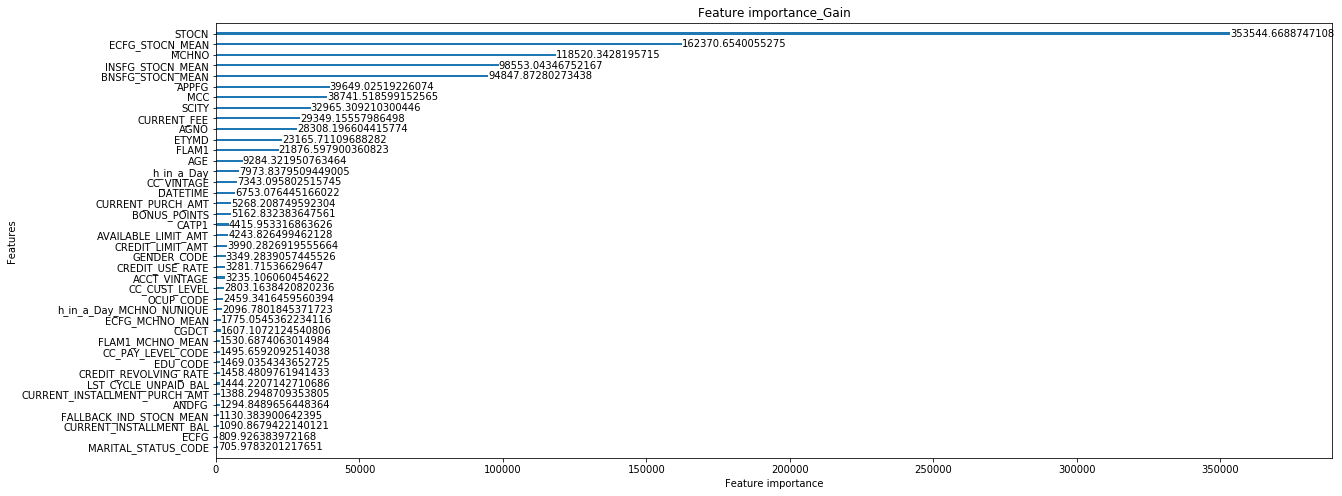

In [30]:
#對test算performance
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
split_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=30, ignore_zero=False,figsize=(11, 6),grid=False, title='Feature importance_Split')
gain_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=40, importance_type='gain',figsize=(20, 8),grid=False, title='Feature importance_Gain')


In [31]:
#對test算 f1_score
from sklearn.metrics import f1_score
y_pred_val = LGBM_grid_final_fit.predict(X_test)
f1_score(y_test,y_pred_val,average=None)

array([0.98676273, 0.91645593])

### 透過 F1 cumulative results檢視成效

In [32]:
def get_lift(prob_data):
    prob_data=prob_data.sort_values(by=['Prob'],ascending=False).reset_index(drop=True)
    prob_data['cnt']=1.0
    prob_data['cumsum']=prob_data.Y.cumsum()
    prob_data['cum_cnt'] = prob_data.cnt.cumsum()
    prob_data['precision'] = prob_data['cumsum']/prob_data['cum_cnt']
    prob_data['recall'] = prob_data['cumsum']/prob_data['cumsum'].max()
    lift_data = prob_data[['precision','recall']].groupby(['recall']).min().reset_index()
    lift_data['f1'] = (2*lift_data.precision*lift_data.recall)/(lift_data.precision+lift_data.recall)
    return lift_data

In [33]:
result = pd.DataFrame(data={'Y':y_test,'Prob':y_pred_val})
result_lift = get_lift(result)

In [34]:
result_lift=result_lift.iloc[1:,:]

In [35]:
result_lift[result_lift.f1==result_lift.f1.max()]

,recall,precision,f1
19930,0.911548,0.921409,0.916452


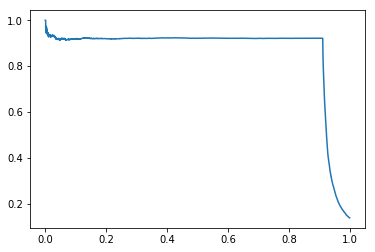

In [36]:
plt.plot(result_lift.recall,result_lift.precision)

In [37]:
#拿全部的dataTrain來建
LGBM_grid_final_fit_all = LGBM_grid_final.fit(X_feature, y_t)

In [38]:
LGBM_grid_final_fit_res =LGBM_grid_final_fit_all.predict_proba(dataTest)

In [39]:
df_p = pd.DataFrame({'p0':LGBM_grid_final_fit_res[:,0],'p1':LGBM_grid_final_fit_res[:,1]})

In [40]:
submit=pd.read_csv('sampleSubmission.csv',encoding='big5')
out = pd.concat([submit, df_p], axis=1, ignore_index=True)
out.sort_values(by=[3], ascending=False, inplace=True)
out.rename(columns={0:'TXKEY', 1:'FRAUD_IND', 2:'p0', 3:'p1'},inplace=True)
print('偽冒機率門檻：',out.iloc[1438,3])#1634=1438/0.88
out.FRAUD_IND[out.p1>=out.iloc[1438,3]]=1

偽冒機率門檻： 0.8903328119162298


In [41]:
ttl= out['FRAUD_IND'].sum()
ttl

1439

In [42]:
out=out[['TXKEY','FRAUD_IND']]
out.to_csv("submit.csv", index= False)

In [43]:
print('This submission: public score: 0.41797 and private score: 0.36770')

This submission: public score: 0.41797 and private score: 0.36770
